<h1 align = 'center'>Face Recognition with Principal Component Analysis

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import IncrementalPCA
import matplotlib.pyplot as plt

In [2]:
TRAINING = "dataset_at&t/Training"
TESTING = "dataset_at&t/Testing"

In [3]:
## Storing Images and corresponding labels
images = list()
labels = list()
for folder in os.listdir(TRAINING):
    for img in os.listdir(TRAINING + "/" + folder):
        img = Image.open(TRAINING + "/" + folder + "/" + img)
        labels.append(int(folder.split("s")[1]))
        images.append(np.array(img))

In [4]:
# Resizing images in the form of a vector and subtracting mean
shape = images[0].shape
X = np.resize(images,(len(images), shape[0]*shape[1]))
mean = np.mean(X, axis = 0)
X_std = X - mean
X_std.shape

(280, 10304)

# Eigendecomposition of the Covariance Matrix

In [5]:
# IMPORTANT, cov matrix here is of dimension m x m instead of the standard d x d
cov_mat = X_std @ X_std.T
cov_mat.shape

(280, 280)

In [6]:
# Eigendecomposition of the covariance matrix followed by sorting of the eigenvectors in decreasing order of the eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]
# Extracting the eigenvectors of the actual covariance matrix from the converted covariance matrix
eigenvector_converted = X_std.T @ eigenvectors
eigenvector_converted.shape

(10304, 280)

In [7]:
# Normalizing the eigenvectors
eigenfaces = eigenvector_converted.T/ np.sqrt((eigenvector_converted.T ** 2).sum(axis=1, keepdims=True))
eigenfaces.shape

(280, 10304)

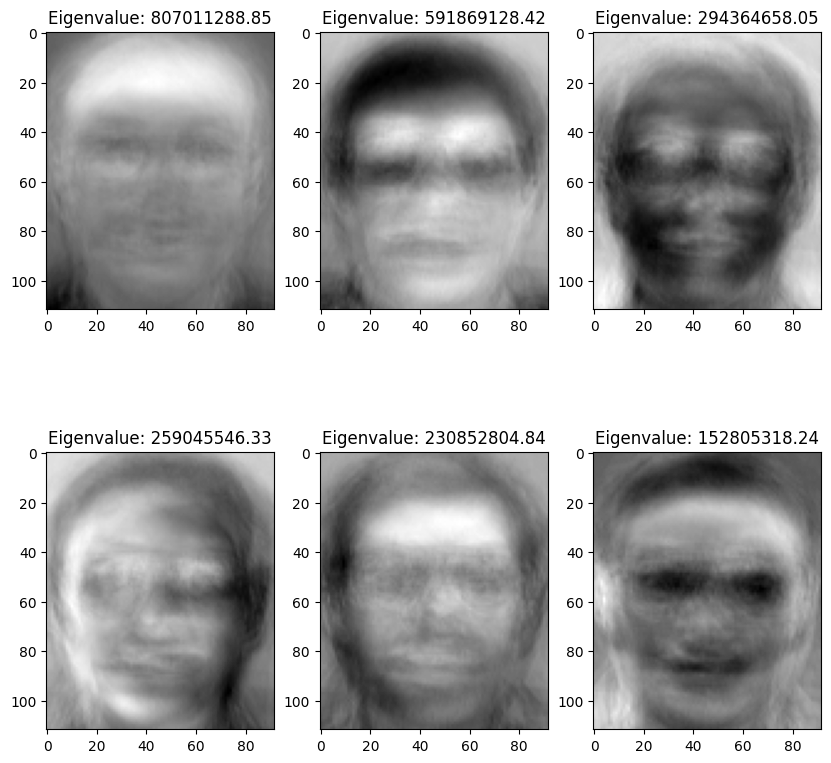

In [8]:
# top 6 Eigenvalues of the covariance matrix Σ
_, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten()
for i, (img, ax) in enumerate(zip(eigenfaces, axs)):
    ax.set_title(f"Eigenvalue: {np.round(eigenvalues[i], 2)}")
    ax.imshow(img.reshape(shape[0], shape[1]), cmap="gray")
plt.show()

In [9]:
# Last Eigenvalue is approximately 0
eigenvalues[-1]

-2.6977513160918557e-08

# Explained Variance in PCA

In [10]:
# Total sum of eigenvalues
total = sum(eigenvalues)

# Explained variance for each eigenvalue
explained_variance = [(i / total) * 100 for i in eigenvalues]
explained_variance = np.round(explained_variance, 2)

# Cumulative explained variance
cum_explained_variance = np.cumsum(explained_variance)

In [11]:
x = list()
# Explained variance thresholdS
y = [85, 95]
for dim in range(280):
    if cum_explained_variance[dim] >= y[0]:
        x.append(dim+1)
        break

for dim in range(x[0]+1, 280):
    if cum_explained_variance[dim] >= y[1]:
        x.append(dim+1)
        break
x

[59, 147]

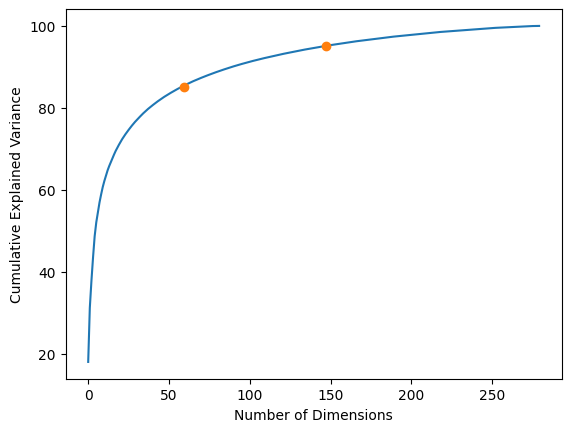

In [12]:
plt.plot(cum_explained_variance)
plt.plot(x, y, "o")
plt.xlabel("Number of Dimensions")
plt.ylabel("Cumulative Explained Variance")
plt.show()

# Projection and Reconstruction

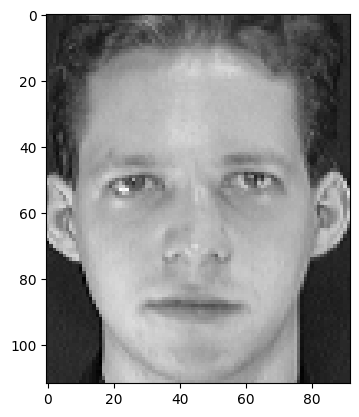

In [13]:
# Train Set
train_img = np.array(Image.open(TRAINING + "/" + "s1/1.pgm"))
train_image_mean_centered = train_img.reshape(shape[0]*shape[1]) - mean
plt.imshow(train_img, cmap = 'gray')
plt.show()

Reconstruction errors: (MSE)
1 eigenfaces: 11787210.479364855
4 eigenfaces: 7528557.971268984
15 eigenfaces: 5320171.437609371
150 eigenfaces: 858899.6269295528
199 eigenfaces: 363420.6130583912
280 eigenfaces: 10.183161109232293


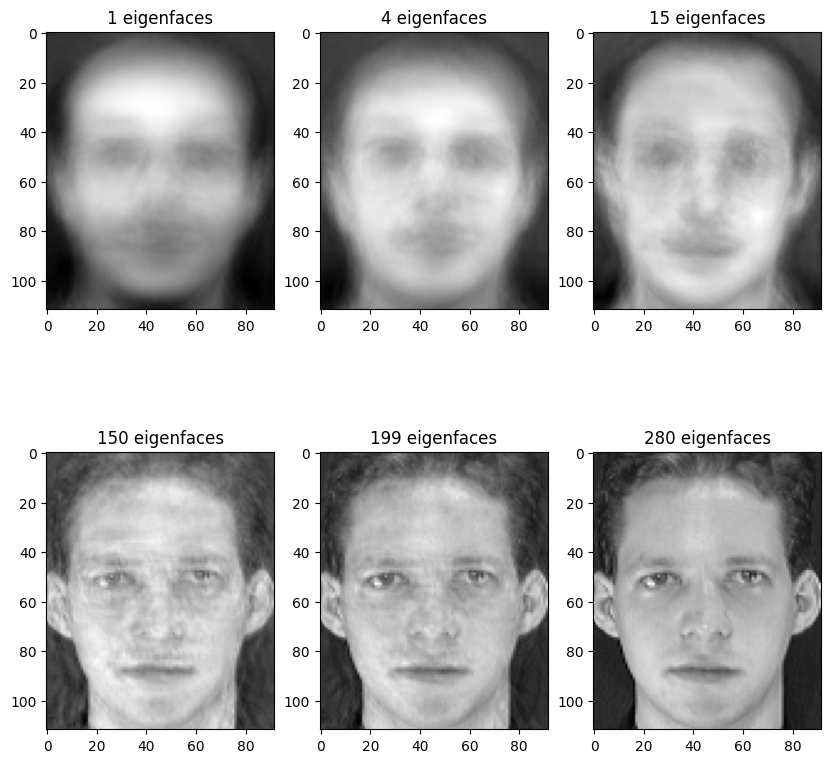

In [ ]:
_, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten()
# number of eigenfaces to use for reconstruction
count = [1, 4, 15, 150, 199, 280]
print("Reconstruction errors: (MSE)")
for i, (img, ax) in enumerate(zip(eigenfaces, axs)):
    E = eigenfaces[:count[i]].dot(train_image_mean_centered)
    reconstruction = eigenfaces[:count[i]].T.dot(E) + mean

    diff = train_image_mean_centered + mean - reconstruction

    # Mean Squared Error (MSE) as the reconstruction error
    error = np.dot(diff, diff)
    print(str(count[i]) + " eigenfaces: " + str(error))

    ax.set_title(str(count[i]) + " eigenfaces")
    ax.imshow(np.reshape(reconstruction, (shape[0], shape[1])), cmap='gray')
plt.show()

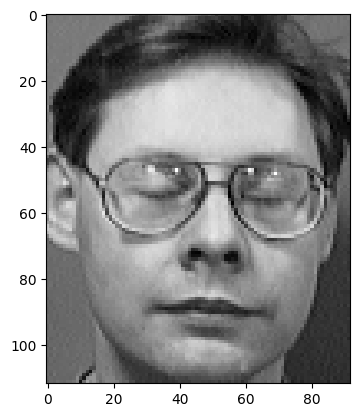

In [15]:
# Test Set
test_img = np.array(Image.open(TESTING + "/" + "s4/9.pgm"))
test_image_mean_centered = test_img.reshape(shape[0]*shape[1]) - mean
plt.imshow(test_img.reshape(shape[0], shape[1]), cmap = 'gray')
plt.show()

Reconstruction errors: (MSE)
1 eigenfaces: 11092527.9847995
4 eigenfaces: 10716266.505263776
15 eigenfaces: 6179847.949328036
150 eigenfaces: 3228284.08434044
199 eigenfaces: 3104830.940544765
280 eigenfaces: 2929500.8152112137


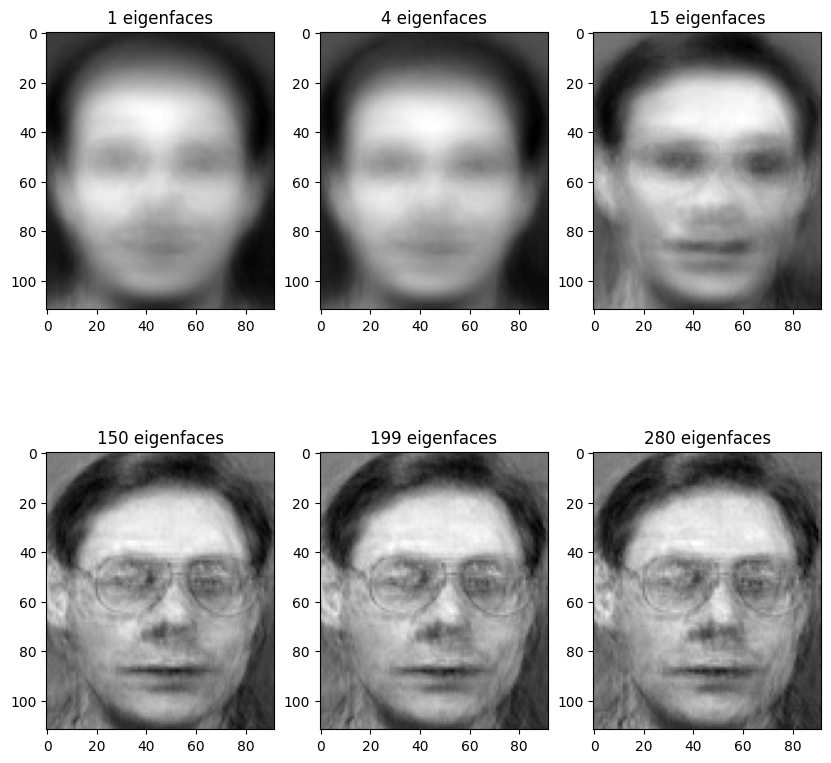

In [ ]:
_, axs = plt.subplots(2, 3, figsize=(10, 10))
axs = axs.flatten()
# Define a list of indices 'count' indicating the number of eigenfaces to use for reconstruction
count = [1, 4, 15, 150, 199, 280]
print("Reconstruction errors: (MSE)")
for i, (img, ax) in enumerate(zip(eigenfaces, axs)):
    # Reconstruction using the selected number of eigenfaces
    E = eigenfaces[:count[i]].dot(test_image_mean_centered)
    reconstruction = eigenfaces[:count[i]].T.dot(E) + mean

    # Difference between the original and reconstructed images
    diff = test_image_mean_centered + mean - reconstruction

    # ean Squared Error (MSE) as the reconstruction error
    error = np.dot(diff, diff)
    print(str(count[i]) + " eigenfaces: " + str(error))

    # Display the reconstructed image in grayscale
    ax.set_title(str(count[i])+" eigenfaces")
    ax.imshow(np.reshape(reconstruction,(shape[0],shape[1])),cmap='gray')
plt.show()

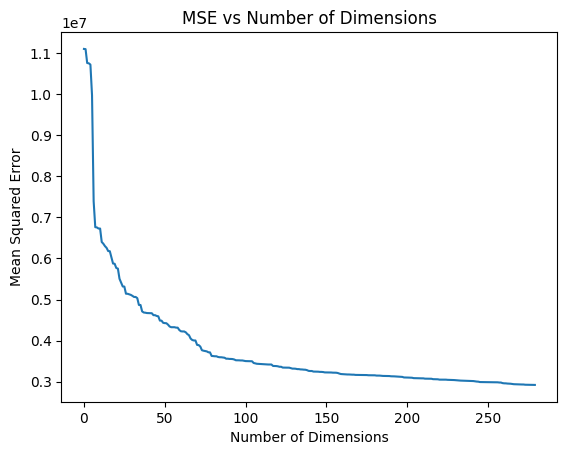

In [ ]:
# Trend of Reconstruction error vs Number of Dimensions used for Reconstruction
errors = list()
for i in range(280):
    E = eigenfaces[:i].dot(test_image_mean_centered)
    reconstruction = eigenfaces[:i].T.dot(E) + mean
    diff = test_image_mean_centered + mean - reconstruction

    # Mean Squared Error (MSE) as the reconstruction error
    error = np.dot(diff, diff)
    errors.append(error)

plt.plot(errors)
plt.title("MSE vs Number of Dimensions")
plt.xlabel("Number of Dimensions")
plt.ylabel("Mean Squared Error")
plt.show()

In [18]:
# Store the lower-dimensional representations
testE = list()  
trainE = list()

#TESTING
for folder in os.listdir(TESTING):
    for img in os.listdir(TESTING + "/" + folder):
        img = np.array(Image.open(TESTING + "/" + folder + "/" + img))

        img_mean_centered = img.reshape(shape[0] * shape[1]) - mean
        testE.append(eigenfaces[:279].dot(img_mean_centered))

#TRAINING
for folder in os.listdir(TRAINING):
    for img in os.listdir(TRAINING + "/" + folder):
        img = np.array(Image.open(TRAINING + "/" + folder + "/" + img))

        img_mean_centered = img.reshape(shape[0] * shape[1]) - mean
        trainE.append(eigenfaces[:279].dot(img_mean_centered))


In [19]:
def predictSingle(img, total, q = 25):
    smallest_value =None
    index = None
    E = testE[total-1][:q]
    for i, image in enumerate(images):
        E_compare = trainE[i][:q]
        diff = E-E_compare
        eps = np.sqrt(np.dot(diff, diff))
        if smallest_value==None:
            smallest_value=eps
            index = labels[i]
        if smallest_value>eps:
            smallest_value=eps
            index=labels[i]
    return index

In [20]:
def predict(q = 25):
    total = 0
    correct = 0
    for folder in os.listdir(TESTING):
        for img in os.listdir(TESTING + "/" + folder):
            img = np.array(Image.open(TESTING + "/" + folder + "/" + img))
            total += 1
            if(predictSingle(img, total, q) == int(folder.split("s")[1])):
                correct += 1
    return correct/total

In [21]:
partA = predict()
print("Classification Accuracy: ", partA)

Classification Accuracy:  0.9666666666666667


In [22]:
accs = list()
for q in range(1, 280):
    accs.append(predict(q))

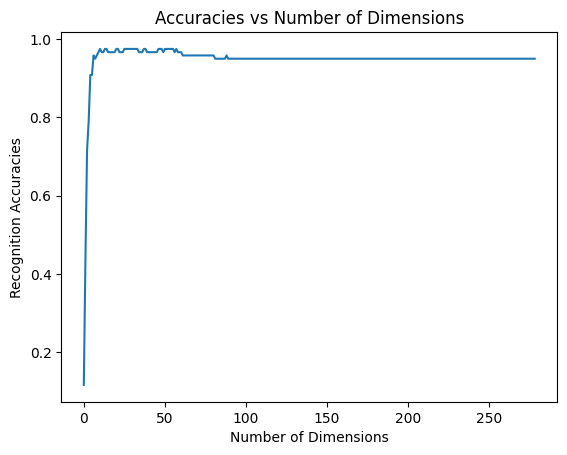

In [23]:
plt.plot(accs)
plt.title("Accuracies vs Number of Dimensions")
plt.xlabel("Number of Dimensions")
plt.ylabel("Recognition Accuracies")
plt.show()

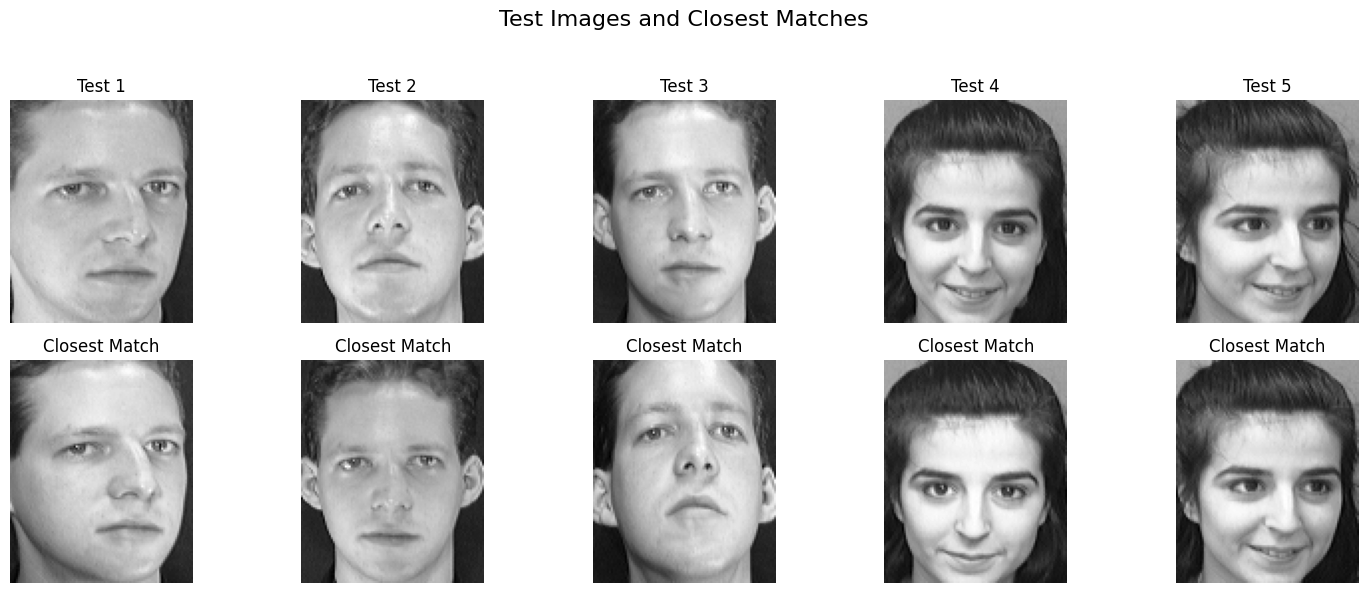

In [ ]:
def display_closest_matches(testE, trainE, test_img_paths, train_img_paths, q=25):
    """
    Displays test images in the top row and their closest matches in the bottom row.
    
    Parameters:
        testE: list of test embeddings in reduced subspace.
        trainE: list of train embeddings in reduced subspace.
        test_img_paths: list of paths to test images.
        train_img_paths: list of paths to train images.
        q: number of dimensions to use for comparison.
    """
    num_samples = 5 
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle("Test Images and Closest Matches", fontsize=16)

    for i in range(num_samples):
        # EmbeddingS
        E_test = testE[i][:q]

        # Closest match using Euclidean distance
        closest_index = None
        smallest_distance = float("inf")
        for j, E_train in enumerate(trainE):
            diff = E_test - E_train[:q]
            distance = np.sqrt(np.dot(diff, diff))
            if distance < smallest_distance:
                smallest_distance = distance
                closest_index = j

        # Test images
        test_img = np.array(Image.open(test_img_paths[i]))
        axes[0, i].imshow(test_img, cmap="gray")
        axes[0, i].set_title(f"Test {i + 1}")
        axes[0, i].axis("off")

        # Closest train image
        train_img = np.array(Image.open(train_img_paths[closest_index]))
        axes[1, i].imshow(train_img, cmap="gray")
        axes[1, i].set_title("Closest Match")
        axes[1, i].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

test_img_paths = []
train_img_paths = []

for folder in os.listdir(TESTING):
    for img in os.listdir(TESTING + "/" + folder):
        test_img_paths.append(TESTING + "/" + folder + "/" + img)

for folder in os.listdir(TRAINING):
    for img in os.listdir(TRAINING + "/" + folder):
        train_img_paths.append(TRAINING + "/" + folder + "/" + img)

display_closest_matches(testE, trainE, test_img_paths, train_img_paths, q=25)


In [25]:
# Incremental PCA 
n_components = 25 
ipca = IncrementalPCA(n_components=n_components)

# Training
def train_ipca(X_train_flat):
    ipca.fit(X_train_flat)
    transformed_features = ipca.transform(X_train_flat)
    return ipca, transformed_features

X_train_flat = np.array([img.reshape(-1) for img in images])
ipca, transformed_features = train_ipca(X_train_flat)

ipca = IncrementalPCA(n_components=n_components)

# Train Incremental PCA with initial data
X_train_flat = X_train_flat.reshape(X_train_flat.shape[0], -1)
ipca.fit(X_train_flat)

IncrementalPCA(n_components=25)

In [26]:
# Initialize Incremental PCA
n_components = 25
ipca = IncrementalPCA(n_components=n_components)

# Flatten Images
def flatten_images(images):
    """
    Flattens a list of images into a 2D array.
    :param images: List or array of images (each image is a 2D array).
    :return: Flattened 2D array of shape [num_samples, num_features].
    """
    return np.array([img.reshape(-1) for img in images])

# Train Incremental PCA
def train_ipca(X_train_flat):
    """
    Trains Incremental PCA on the training set.
    :param X_train_flat: Flattened training images (2D array).
    :return: Trained IncrementalPCA object, mean face, transformed features.
    """
    ipca = IncrementalPCA(n_components=n_components)
    ipca.fit(X_train_flat)
    mean_face = np.mean(X_train_flat, axis=0)
    transformed_features = ipca.transform(X_train_flat)
    return ipca, mean_face, transformed_features

# Add a new face to the dataset
def add_face(ipca, new_face_flat, X_train_flat):
    """
    Adds a new face to the training set and updates Incremental PCA.
    """
    X_train_flat_updated = np.vstack([X_train_flat, new_face_flat])
    ipca.partial_fit(X_train_flat_updated)
    updated_transformed_features = ipca.transform(X_train_flat_updated)
    return ipca, X_train_flat_updated, updated_transformed_features

# Remove a face from the dataset
def remove_face(ipca, face_index, X_train_flat):
    """
    Removes a face from the training set and updates Incremental PCA.
    """
    X_train_flat_updated = np.delete(X_train_flat, face_index, axis=0)
    ipca = IncrementalPCA(n_components=n_components)
    ipca.fit(X_train_flat_updated)
    transformed_features = ipca.transform(X_train_flat_updated)
    return ipca, X_train_flat_updated, transformed_features


In [27]:
ipca = IncrementalPCA(n_components=25)
ipca.fit(X_train_flat)

# Initial Evaluation After Default PCA Fit
explained_variance_initial = np.cumsum(ipca.explained_variance_ratio_)
print(f"Initial Explained Variance for {ipca.n_components} components: {explained_variance_initial[-1] * 100:.2f}%")
print(f"Initial Classification Accuracy: {predict(q=25) * 100:.2f}%")
print(f"Initial shape of X_train_flat: {X_train_flat.shape}")
print(f"Initial shape of transformed_features: {transformed_features.shape}")

# Add a New Face
new_face_flat = np.random.rand(X_train_flat.shape[1])
ipca, X_train_flat, transformed_features = add_face(ipca, new_face_flat, X_train_flat)

# Evaluation After Adding New Face
explained_variance_added = np.cumsum(ipca.explained_variance_ratio_)
print(f"Explained Variance After Adding New Face: {explained_variance_added[-1] * 100:.2f}%")
print(f"Updated Classification Accuracy After Adding New Face: {predict(q=25) * 100:.2f}%")
print(f"Shape of X_train_flat after adding new face: {X_train_flat.shape}")
print(f"Shape of transformed_features after adding new face: {transformed_features.shape}")

#Remove a Face
face_index_to_remove = 5 
ipca, X_train_flat, transformed_features = remove_face(ipca, face_index_to_remove, X_train_flat)

# Evaluation After Removing a Face
explained_variance_removed = np.cumsum(ipca.explained_variance_ratio_)
print(f"Explained Variance After Removing a Face: {explained_variance_removed[-1] * 100:.2f}%")
print(f"Updated Classification Accuracy After Removing a Face: {predict(q=25) * 100:.2f}%")
print(f"Shape of X_train_flat after removing a face: {X_train_flat.shape}")
print(f"Shape of transformed_features after removing a face: {transformed_features.shape}")


Initial Explained Variance for 25 components: 74.04%
Initial Classification Accuracy: 96.67%
Initial shape of X_train_flat: (280, 10304)
Initial shape of transformed_features: (280, 25)
Explained Variance After Adding New Face: 74.37%
Updated Classification Accuracy After Adding New Face: 96.67%
Shape of X_train_flat after adding new face: (281, 10304)
Shape of transformed_features after adding new face: (281, 25)
Explained Variance After Removing a Face: 74.72%
Updated Classification Accuracy After Removing a Face: 96.67%
Shape of X_train_flat after removing a face: (280, 10304)
Shape of transformed_features after removing a face: (280, 25)
